# EasyEdit Example with **ROME**
> Tutorial author: Peng Wang（<peng2001@zju.edu.cn>）
In this tutorial, we use `ROME` to edit `gpt2` model. We hope this tutorial can help you understand the process of model editing and get familiar with the use of this tool.

This tutorial uses `Python3`.

# Model Editing
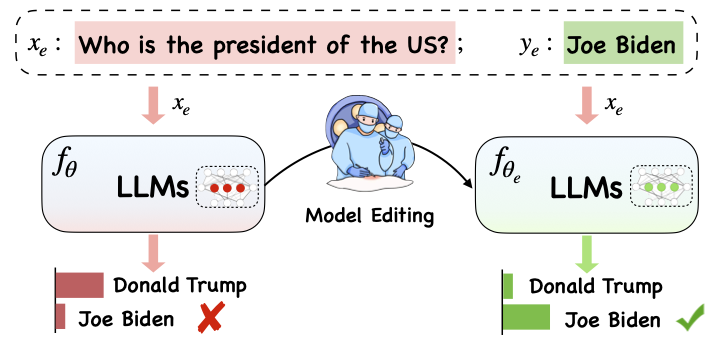

Deployed models may still make unpredictable errors. For example, Large Language Models (LLMs) notoriously *hallucinate*, *perpetuate bias*, and *factually decay*, so we should be able to adjust specific behaviors of pre-trained models.

**Model editing** aims to adjust an initial base model's $(f_\theta)$ behavior on the particular edit descriptor $[x_e, y_e]$, such as:
- $x_e$: "Who is the president of the US?
- $y_e$: "Joe Biden."

efficiently without influencing the model behavior on unrelated samples. The ultimate goal is to create an edited model$(f_\theta’)$.

# Editing Scope
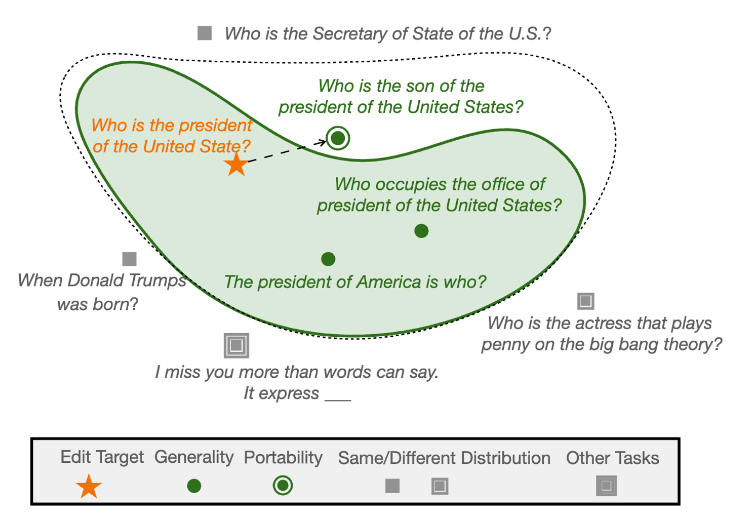

The model editing process generally impacts the predictions for a broad set of inputs **that are closely** associated with the edit example, called the **editing scope**.


A successful edit should adjust the model’s behavior within the editing scope while remaining unrelated inputs(as below formula).


$f_{\theta_{e}}(x) = \begin{cases}
y_e & \text{if } x \in I(x_e,y_e) \\
f_{\theta}(x) & \text{if } x \in O(x_e, y_e) \end{cases}$

In addition to this, the performance of model editing should be measured from multiple dimensions:

- `Reliability`: the success rate of editing with a given editing description
- `Generalization`: the success rate of editing **within** the editing scope
- `Locality`: whether the model's output changes after editing for unrelated inputs
- `Portability`: the success rate of editing for factual reasoning(one hop, synonym, one-to-one relation)
- `Efficiency`: time and memory consumption required during the editing process


# Method: **ROME**

Paper:[Locating and Editing Factual Associations in GPT](https://arxiv.org/abs/2202.05262)
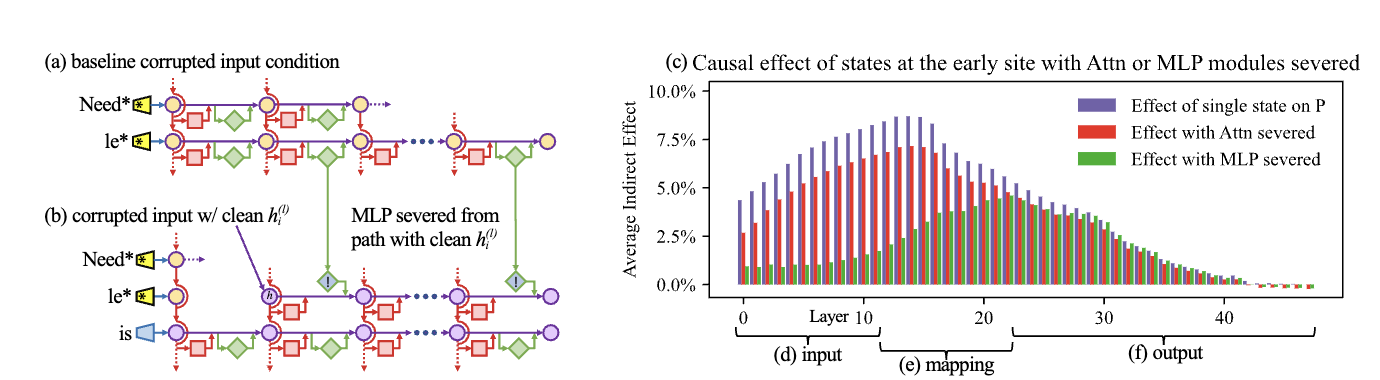

## Prepare the runtime environment

In [ ]:
## Clone Repo
# !git clone https://github.com/zjunlp/EasyEdit
%cd drive/MyDrive/Model-Editing/EasyEdit
!ls

/content/drive/MyDrive/Model-Editing/EasyEdit
Anaconda3-2023.03-1-Linux-x86_64.sh  figs	    logs
data				     get-pip.py     README.md
easyeditor			     globals.yml    requirements.txt
edit_memit_gpt2.py		     hparams	    scripts
edit.py				     hugging_cache
experiments			     LICENSE


In [ ]:
!apt-get install python3.9

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib python3.9-minimal
Suggested packages:
  python3.9-venv binfmt-support
The following NEW packages will be installed:
  libpython3.9-minimal libpython3.9-stdlib python3.9 python3.9-minimal
0 upgraded, 4 newly installed, 0 to remove and 15 not upgraded.
Need to get 5,030 kB of archives.
After this operation, 19.7 MB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 libpython3.9-minimal amd64 3.9.17-1+focal1 [805 kB]
Get:2 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 python3.9-minimal amd64 3.9.17-1+focal1 [2,064 kB]
Get:3 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 libpython3.9-stdlib amd64 3.9.17-1+focal1 [1,666 kB]
Get:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 python3.9 amd64 3.

In [ ]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1
!sudo update-alternatives --config python3

There are 3 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                 Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.10   2         auto mode
  1            /usr/bin/python3.10   2         manual mode
  2            /usr/bin/python3.8    1         manual mode
  3            /usr/bin/python3.9    1         manual mode

Press <enter> to keep the current choice[*], or type selection number: 3
update-alternatives: using /usr/bin/python3.9 to provide /usr/bin/python3 (python3) in manual mode


In [ ]:
!apt-get install python3-pip
!pip install -r requirements.txt

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  python-pip-whl python3-setuptools python3-wheel
Suggested packages:
  python-setuptools-doc
The following NEW packages will be installed:
  python-pip-whl python3-pip python3-setuptools python3-wheel
0 upgraded, 4 newly installed, 0 to remove and 15 not upgraded.
Need to get 2,389 kB of archives.
After this operation, 4,933 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 python-pip-whl all 20.0.2-5ubuntu1.9 [1,805 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 python3-setuptools all 45.2.0-1ubuntu0.1 [330 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 python3-wheel all 0.34.2-1ubuntu0.1 [23.9 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 python3-pip all 20.0.2-5ubuntu1.9 [231 kB]
Fetched 2,389 kB in 0s (16

In [ ]:
!pip list

Package                   Version             
------------------------- --------------------
aiohttp                   3.8.1               
aiosignal                 1.2.0               
antlr4-python3-runtime    4.8                 
anyio                     3.7.1               
argon2-cffi               21.3.0              
argon2-cffi-bindings      21.2.0              
arrow                     1.2.3               
asttokens                 2.2.1               
async-timeout             4.0.2               
attrs                     23.1.0              
backcall                  0.2.0               
backports.csv             1.0.7               
base58                    2.1.1               
beautifulsoup4            4.12.2              
black                     22.1.0              
bleach                    6.0.0               
blessed                   1.20.0              
blis                      0.7.5               
boto3                     1.20.47             
botocore     

## Config Method Parameters
> xxx/gpt2.yaml (8GB is OK!)




```python
# For ROME hparams:

alg_name: "ROME"
model_name: "./hugging_cache/gpt2"
device: 0
layers: [9]
fact_token: "subject_last"
v_num_grad_steps: 23
v_lr: 5e-1
v_loss_layer: 11
v_weight_decay: 0.0015
clamp_norm_factor: 4
kl_factor: 0.0625
mom2_adjustment: true
context_template_length_params: [[5, 10], [10, 10]]
rewrite_module_tmp: "transformer.h.{}.mlp.c_proj"
layer_module_tmp: "transformer.h.{}"
mlp_module_tmp: "transformer.h.{}.mlp"
attn_module_tmp: "transformer.h.{}.attn"
ln_f_module: "transformer.ln_f"
lm_head_module: "transformer.wte"
mom2_dataset: "wikipedia"
mom2_n_samples: 1000
mom2_dtype: "float32"
```



In [ ]:
!pip install matplotlib
!pip install sentence_transformers

Processing /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f/sentence_transformers-2.2.2-py3-none-any.whl
     |████████████████████████████████| 6.0 MB 13.1 MB/s 
     |████████████████████████████████| 10.9 MB 62.8 MB/s 
     |████████████████████████████████| 1.3 MB 83.9 MB/s 
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
ERROR: torchvision 0.15.2 has requirement torch==2.0.1, but you'll have torch 1.10.2 which is incompatible.
ERROR: scikit-learn 1.3.0 has requirement joblib>=1.1.1, but you'll have joblib 1.1.0 which is incompatible.


## Import modules & Run

In [4]:
import os,sys
os.chdir("/root/EasyEdit")
from easyeditor import BaseEditor
from easyeditor import ROMEHyperParams



prompts = ['Ray Charles, the',
            'Grant Hill is a professional',
            'The law in Ikaalinen declares the language'
            ]
ground_truth = ['piano',
                'basketball',
                'Finnish'
                ]
target_new = ['violin',
              'soccer',
              'Swedish'
              ]
subject = ['Ray Charles',
            'Grant Hill',
            'Ikaalinen'
            ]

hparams = ROMEHyperParams.from_hparams('./hparams/ROME/gpt2-xl.yaml')
editor = BaseEditor.from_hparams(hparams)
metrics, edited_model, _ = editor.edit(
    prompts=prompts,
    ground_truth=ground_truth,
    target_new=target_new,
    subject=subject,
    keep_original_weight=True
)

print(metrics)


print('*'*20)

from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('/root/autodl-tmp/gpt2-xl')
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side='left'
generation_prompts = [
    "Ray Charles, the",
    "The law in Ikaalinen declares the language"
]

model = GPT2LMHeadModel.from_pretrained('/root/autodl-tmp/gpt2-xl').to('cuda')
batch = tokenizer(generation_prompts, return_tensors='pt', padding=True, max_length=30)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_length=20
)

post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_length=20
)

2024-05-26 09:36:56,331 - easyeditor.editors.editor - INFO - Instantiating model
2024-05-26 09:36:56,331 - easyeditor.editors.editor - INFO - Instantiating model
05/26/2024 09:36:56 - INFO - easyeditor.editors.editor -   Instantiating model
100%|██████████| 3/3 [00:00<00:00, 14.74it/s]


Executing ROME algorithm for the update: [Ray Charles, the] -> [ violin]
Computing left vector (u)...
Selected u projection object Ray Charles
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 1 | Sentence: Ray Charles, the | Token:  Charles
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 10.598 = 10.598 + 0.0 + 0.0 avg prob of [ violin] 2.707894964260049e-05
loss 7.003 = 6.975 + 0.009 + 0.019 avg prob of [ violin] 0.0009730856982059777
loss 4.71 = 4.652 + 0.026 + 0.032 avg prob of [ violin] 0.010422359220683575
loss 3.146 = 3.068 + 0.034 + 0.044 avg prob of [ violin] 0.05039922893047333
loss 1.919 = 1.819 + 0.046 + 0.055 avg prob of [ violin] 0.1739020198583603
loss 0.912 = 0.769 + 0.079 + 0.064 avg prob of [ violin] 0.4859868884086609
loss 0.445 = 0.263 + 0.109 + 0.073 avg prob of [ violin] 0.7775673866271973
loss 0.279 = 0.124 + 0.074 + 0.082 avg prob of [ violin] 0.8860873579978943
loss 0.219 = 0.079 + 0.0

2024-05-26 09:37:10,288 - easyeditor.editors.editor - INFO - Execution 0 editing took 6.00308084487915
2024-05-26 09:37:10,288 - easyeditor.editors.editor - INFO - Execution 0 editing took 6.00308084487915
05/26/2024 09:37:10 - INFO - easyeditor.editors.editor -   Execution 0 editing took 6.00308084487915
2024-05-26 09:37:10,357 - easyeditor.editors.editor - INFO - Evaluation took 0.06682920455932617
2024-05-26 09:37:10,357 - easyeditor.editors.editor - INFO - Evaluation took 0.06682920455932617
05/26/2024 09:37:10 - INFO - easyeditor.editors.editor -   Evaluation took 0.06682920455932617
2024-05-26 09:37:10,359 - easyeditor.editors.editor - INFO - 0 editing: Ray Charles, the -> violin  
 {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Ray Charles, the', 'target_new': 'violin', 'ground_truth': 'piano', 'portability': {}, 'locality': {}, 'subject': 'Ray Charles'}, 'time': 6.00308084487915, 'post': {'rewrite_acc': [1.0], 'locality': {}, '

loss 0.129 = 0.006 + 0.037 + 0.086 avg prob of [ violin] 0.9941848516464233
Delta norm: 92.51285552978516
Change in target norm: 23.128215789794922 to 95.54093170166016 => 72.4127197265625
Division Factor: 13.210683822631836
Right vector norm: 7.00288200378418
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Grant Hill is a professional] -> [ soccer]
Computing left vector (u)...
Selected u projection object Grant Hill
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 1 | Sentence: Grant Hill is a professional | Token:  Hill
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 5.895 = 5.895 + 0.0 + 0.0 avg prob of [ soccer] 0.0038826926611363888
loss 4.043 = 4.019 + 0.006 + 0.018 avg prob of [ soccer] 0.022225594148039818
loss 2.465 = 2.

2024-05-26 09:37:16,404 - easyeditor.editors.editor - INFO - Execution 1 editing took 6.04309344291687
2024-05-26 09:37:16,404 - easyeditor.editors.editor - INFO - Execution 1 editing took 6.04309344291687
05/26/2024 09:37:16 - INFO - easyeditor.editors.editor -   Execution 1 editing took 6.04309344291687
2024-05-26 09:37:16,475 - easyeditor.editors.editor - INFO - Evaluation took 0.06909656524658203
2024-05-26 09:37:16,475 - easyeditor.editors.editor - INFO - Evaluation took 0.06909656524658203
05/26/2024 09:37:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.06909656524658203
2024-05-26 09:37:16,477 - easyeditor.editors.editor - INFO - 1 editing: Grant Hill is a professional -> soccer  
 {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 1, 'requested_rewrite': {'prompt': 'Grant Hill is a professional', 'target_new': 'soccer', 'ground_truth': 'basketball', 'portability': {}, 'locality': {}, 'subject': 'Grant Hill'}, 'time': 6.04309344291687, 'post': {'rewrite_ac

loss 0.122 = 0.019 + 0.019 + 0.085 avg prob of [ soccer] 0.9813396334648132
Delta norm: 94.66288757324219
Change in target norm: 23.66572380065918 to 98.17730712890625 => 74.51158142089844
Division Factor: 14.136372566223145
Right vector norm: 6.69640588760376
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The law in Ikaalinen declares the language] -> [ Swedish]
Computing left vector (u)...
Selected u projection object Ikaalinen
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The law in Ikaalinen declares the language | Token: en
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.87 = 9.87 + 0.0 + 0.0 avg prob of [ Swedish] 6.724185368511826e-05
loss 8.168 = 8.132 + 0.006 + 0.03 avg prob of [ Swedish] 0.0004286204

2024-05-26 09:37:24,024 - easyeditor.editors.editor - INFO - Execution 2 editing took 7.546124458312988
2024-05-26 09:37:24,024 - easyeditor.editors.editor - INFO - Execution 2 editing took 7.546124458312988
05/26/2024 09:37:24 - INFO - easyeditor.editors.editor -   Execution 2 editing took 7.546124458312988
2024-05-26 09:37:24,093 - easyeditor.editors.editor - INFO - Evaluation took 0.06660127639770508
2024-05-26 09:37:24,093 - easyeditor.editors.editor - INFO - Evaluation took 0.06660127639770508
05/26/2024 09:37:24 - INFO - easyeditor.editors.editor -   Evaluation took 0.06660127639770508
2024-05-26 09:37:24,095 - easyeditor.editors.editor - INFO - 2 editing: The law in Ikaalinen declares the language -> Swedish  
 {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 2, 'requested_rewrite': {'prompt': 'The law in Ikaalinen declares the language', 'target_new': 'Swedish', 'ground_truth': 'Finnish', 'portability': {}, 'locality': {}, 'subject': 'Ikaalinen'}, 'time': 7.5461244

loss 0.147 = 0.004 + 0.033 + 0.109 avg prob of [ Swedish] 0.9957219362258911
Delta norm: 73.40951538085938
Change in target norm: 18.352378845214844 to 74.62544250488281 => 56.27306365966797
Division Factor: 13.669368743896484
Right vector norm: 5.370366096496582
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
[{'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Ray Charles, the', 'target_new': 'violin', 'ground_truth': 'piano', 'portability': {}, 'locality': {}, 'subject': 'Ray Charles'}, 'time': 6.00308084487915, 'post': {'rewrite_acc': [1.0], 'locality': {}, 'portability': {}}}, {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 1, 'requested_rewrite': {'prompt': 'Grant Hill is a professional', 'target_new': 'soccer', 'ground_truth': 'basketball', 'portability': {}, 'locality': {}, 'subje

In [5]:
print('Pre-Edit Outputs: ', [tokenizer.decode(x) for x in pre_edit_outputs.detach().cpu().numpy().tolist()])
print('Post-Edit Outputs: ', [tokenizer.decode(x) for x in post_edit_outputs.detach().cpu().numpy().tolist()])

Pre-Edit Outputs:  ['<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Ray Charles, the legendary singer, songwriter and actor, died on', 'The law in Ikaalinen declares the language to be a "national language" and requires that']
Post-Edit Outputs:  ['<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Ray Charles, the legendary singer, songwriter and actor, died on', 'The law in Ikaalinen declares the language to be a "national language" and requires that']


In [3]:
pre_edit_outputs

tensor([[50256, 50256, 50256, 50256, 50256, 50256, 19591,  7516,    11,   262,
         13273, 14015,    11,  3496, 16002,   290,  8674,    11,  3724,   319],
        [  464,  1099,   287,   314,  4914, 14414,   268, 24183,   262,  3303,
           284,   307,   257,   366, 14648,  3303,     1,   290,  4433,   326]],
       device='cuda:0')

In [1]:
import os,sys
os.chdir("/root/EasyEdit")
from easyeditor import BaseEditor
from easyeditor import ROMEHyperParams



prompts = ['Ray Charles, the',
            'Grant Hill is a professional',
            'The law in Ikaalinen declares the language'
            ]
ground_truth = ['piano',
                'basketball',
                'Finnish'
                ]
target_new = ['violin',
              'soccer',
              'Swedish'
              ]
subject = ['Ray Charles',
            'Grant Hill',
            'Ikaalinen'
            ]

hparams = ROMEHyperParams.from_hparams('./hparams/ROME/gpt2-xl')
editor = BaseEditor.from_hparams(hparams)
metrics, edited_model, _ = editor.edit(
    prompts=prompts,
    ground_truth=ground_truth,
    target_new=target_new,
    subject=subject,
    keep_original_weight=False
)

print('*'*100)

from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('/root/autodl-tmp/gpt2-xl')
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side='left'
generation_prompts = [
    "Ray Charles, the",
    "The law in Ikaalinen declares the language"
]

model = GPT2LMHeadModel.from_pretrained('/root/autodl-tmp/gpt2-xl').to('cuda')
batch = tokenizer(generation_prompts, return_tensors='pt', padding=True, max_length=30)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_new_tokens=10
)
post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_new_tokens=10
)
print('Pre-Edit Outputs: ', [tokenizer.decode(x) for x in pre_edit_outputs.detach().cpu().numpy().tolist()])
print('Post-Edit Outputs: ', [tokenizer.decode(x) for x in post_edit_outputs.detach().cpu().numpy().tolist()])
exit()

2024-05-26 09:42:25,634 - easyeditor.editors.editor - INFO - Instantiating model
05/26/2024 09:42:25 - INFO - easyeditor.editors.editor -   Instantiating model
/root/miniconda3/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Executing ROME algorithm for the update: [Ray Charles, the] -> [ violin]
Cached context templates ['{}', 'The first thing I did. {}', 'The most common form of. {}', 'Therefore, if we are. {}', 'Therefore, I would suggest. {}', 'Because it is not a. {}', "Because I'm the only. {}", 'I am very proud to. {}', "I'm going to be. {}", "You'll be able to. {}", 'You can find the latest. {}', 'The most recent data from the U.S.. {}', 'The same day, I received a message from the. {}', 'Therefore I have come to the conclusion that the time. {}', 'Therefore, the question arises whether the government should be. {}', "Because it's the first day and you've just. {}", 'Because of this, I have decided to make this. {}', 'I think the most important thing that I can say. {}', 'I have to admit to being surprised that the ". {}', 'You\'re going to be fine." ". {}', "You'll see a lot more of that in the. {}"]
Computing left vector (u)...
Selected u projection object Ray Charles
Left vector shape: torch.Siz

2024-05-26 09:42:45,144 - easyeditor.editors.editor - INFO - Execution 0 editing took 7.685008525848389
05/26/2024 09:42:45 - INFO - easyeditor.editors.editor -   Execution 0 editing took 7.685008525848389
2024-05-26 09:42:45,214 - easyeditor.editors.editor - INFO - Evaluation took 0.06815695762634277
05/26/2024 09:42:45 - INFO - easyeditor.editors.editor -   Evaluation took 0.06815695762634277
2024-05-26 09:42:45,217 - easyeditor.editors.editor - INFO - 0 editing: Ray Charles, the -> violin  
 {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Ray Charles, the', 'target_new': 'violin', 'ground_truth': 'piano', 'portability': {}, 'locality': {}, 'subject': 'Ray Charles'}, 'time': 7.685008525848389, 'post': {'rewrite_acc': [1.0], 'locality': {}, 'portability': {}}}
05/26/2024 09:42:45 - INFO - easyeditor.editors.editor -   0 editing: Ray Charles, the -> violin  
 {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 0, 'requested_re

loss 0.129 = 0.006 + 0.037 + 0.086 avg prob of [ violin] 0.9941848516464233
Delta norm: 92.51285552978516
Change in target norm: 23.128215789794922 to 95.54093170166016 => 72.4127197265625
Division Factor: 13.210683822631836
Right vector norm: 7.00288200378418
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [Grant Hill is a professional] -> [ soccer]
Computing left vector (u)...
Selected u projection object Grant Hill
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 1 | Sentence: Grant Hill is a professional | Token:  Hill
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 5.054 = 5.054 + 0.0 + 0.0 avg prob of [ soccer] 0.007111888844519854
loss 4.008 = 3.993 + 0.008 + 0.007 avg prob of [ soccer] 0.023177307099103928
loss 1.324 = 1.3

2024-05-26 09:42:51,630 - easyeditor.editors.editor - INFO - Execution 1 editing took 6.411961078643799
05/26/2024 09:42:51 - INFO - easyeditor.editors.editor -   Execution 1 editing took 6.411961078643799
2024-05-26 09:42:51,699 - easyeditor.editors.editor - INFO - Evaluation took 0.06673789024353027
05/26/2024 09:42:51 - INFO - easyeditor.editors.editor -   Evaluation took 0.06673789024353027
2024-05-26 09:42:51,700 - easyeditor.editors.editor - INFO - 1 editing: Grant Hill is a professional -> soccer  
 {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 1, 'requested_rewrite': {'prompt': 'Grant Hill is a professional', 'target_new': 'soccer', 'ground_truth': 'basketball', 'portability': {}, 'locality': {}, 'subject': 'Grant Hill'}, 'time': 6.411961078643799, 'post': {'rewrite_acc': [1.0], 'locality': {}, 'portability': {}}}
05/26/2024 09:42:51 - INFO - easyeditor.editors.editor -   1 editing: Grant Hill is a professional -> soccer  
 {'pre': {'rewrite_acc': [0.0], 'portab

loss 0.074 = 0.018 + 0.02 + 0.036 avg prob of [ soccer] 0.9821851849555969
Delta norm: 108.59513854980469
Change in target norm: 38.99585723876953 to 118.60221099853516 => 79.60635375976562
Division Factor: 14.136372566223145
Right vector norm: 7.681966304779053
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
Executing ROME algorithm for the update: [The law in Ikaalinen declares the language] -> [ Swedish]
Computing left vector (u)...
Selected u projection object Ikaalinen
Left vector shape: torch.Size([6400])
Computing right vector (v)
Lookup index found: 6 | Sentence: The law in Ikaalinen declares the language | Token: en
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 9.788 = 9.788 + 0.0 + 0.0 avg prob of [ Swedish] 7.321024168049917e-05
loss 7.969 = 7.94 + 0.005 + 0.024 avg prob of [ Swedish] 0.000500

2024-05-26 09:42:59,455 - easyeditor.editors.editor - INFO - Execution 2 editing took 7.753770589828491
05/26/2024 09:42:59 - INFO - easyeditor.editors.editor -   Execution 2 editing took 7.753770589828491
2024-05-26 09:42:59,529 - easyeditor.editors.editor - INFO - Evaluation took 0.07162642478942871
05/26/2024 09:42:59 - INFO - easyeditor.editors.editor -   Evaluation took 0.07162642478942871
2024-05-26 09:42:59,531 - easyeditor.editors.editor - INFO - 2 editing: The law in Ikaalinen declares the language -> Swedish  
 {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 2, 'requested_rewrite': {'prompt': 'The law in Ikaalinen declares the language', 'target_new': 'Swedish', 'ground_truth': 'Finnish', 'portability': {}, 'locality': {}, 'subject': 'Ikaalinen'}, 'time': 7.753770589828491, 'post': {'rewrite_acc': [1.0], 'locality': {}, 'portability': {}}}
05/26/2024 09:42:59 - INFO - easyeditor.editors.editor -   2 editing: The law in Ikaalinen declares the language -> Swedish 

loss 0.134 = 0.001 + 0.035 + 0.098 avg prob of [ Swedish] 0.9991586208343506
Delta norm: 82.00291442871094
Change in target norm: 20.500728607177734 to 84.5882568359375 => 64.0875244140625
Division Factor: 13.669368743896484
Right vector norm: 5.999027252197266
Right vector shape: torch.Size([1600])
Deltas successfully computed for ['transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.17.mlp.c_proj.weight']
****************************************************************************************************


/root/miniconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2717: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Pre-Edit Outputs:  ['<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Ray Charles, the legendary singer, songwriter and actor, died on', 'The law in Ikaalinen declares the language to be a "national language" and requires that']
Post-Edit Outputs:  ['<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Ray Charles, the violinist, was a violinist. He was', 'The law in Ikaalinen declares the language Swedish. In Swedish there is no difference between English']


: 

In [ ]:
print("ok")